In [55]:
#created a data frame with specific labels and date format
files <- list.files(path = "solar_data", full.names = TRUE)

data_list <- lapply(files, function(file) {
    read.table(file, skip = 12, header = FALSE, sep = "")
})

# Define column names
column_names <- c(
    "Year", "Month", "Day", 
    "RadioFlux", "SunspotNumber", "SunspotArea", 
    "NewRegions", "MeanField", "SolarBkgdFlux", 
    "XRayC", "XRayM", "XRayX", 
    "OpticalS", "Optical1", "Optical2", "Optical3"
)

data_list <- lapply(data_list, function(df) {
    colnames(df) <- column_names
    
    df$Date <- as.Date(paste(df$Year, sprintf("%02d", df$Month),
                             sprintf("%02d", df$Day), sep = ""),
                       "%Y%m%d")
    
    df <- df[, !colnames(df) %in% c("Year", "Month", "Day")]
    df <- df[, c("Date", setdiff(colnames(df), "Date"))]
    
    return(df)
})

df <- do.call(rbind, data_list)

In [56]:
#summary of the dataset columns
df$MeanField[df$MeanField == -999] <- NA
summary(df)
#ranges and magnitudes seem more or less similar across 
#Optical and X-Ray tables, but those 
#are different units of measurement so they can't be quite compared
#replaced MeanField -999 data points with NA

      Date              RadioFlux     SunspotNumber     SunspotArea    
 Min.   :2014-01-01   Min.   : -1.0   Min.   :  0.00   Min.   :   0.0  
 1st Qu.:2016-07-01   1st Qu.: 71.0   1st Qu.:  0.00   1st Qu.:   0.0  
 Median :2018-12-30   Median : 85.0   Median : 31.00   Median : 160.0  
 Mean   :2018-12-30   Mean   :100.8   Mean   : 49.19   Mean   : 344.1  
 3rd Qu.:2021-06-29   3rd Qu.:126.0   3rd Qu.: 81.00   3rd Qu.: 540.0  
 Max.   :2023-12-30   Max.   :343.0   Max.   :296.00   Max.   :3120.0  
                                                                       
   NewRegions      MeanField    SolarBkgdFlux      XRayC       
 Min.   :0.000   Min.   : NA    *      :1395   Min.   : 0.000  
 1st Qu.:0.000   1st Qu.: NA    A0.0   : 239   1st Qu.: 0.000  
 Median :0.000   Median : NA    B1.0   :  35   Median : 0.000  
 Mean   :0.434   Mean   :NaN    A6.3   :  32   Mean   : 2.499  
 3rd Qu.:1.000   3rd Qu.: NA    B1.1   :  28   3rd Qu.: 4.000  
 Max.   :6.000   Max.   : NA    B2.2   :

In [57]:
#days with highest and lowest radio flux
max_flux <- max(df$RadioFlux, na.rm = TRUE)
min_flux <- min(df$RadioFlux, na.rm = TRUE)

max_flux_days <- df$Date[df$RadioFlux == max_flux]
min_flux_days <- df$Date[df$RadioFlux == min_flux]

max_flux_days
min_flux_days

#2023-02-17 had the highest value for radio flux
#2022-12-16 had the lowest value for radio flux

[1] "2023-02-17"

[1] "2022-12-16"

In [58]:
#calculating the days with the highest number of solar flares 
#and a number of days without any
df$total_flares <- with(df, XRayC + XRayM + XRayX)

max_flares <- max(df$total_flares, na.rm = TRUE)
max_flares_dates <- df$Date[df$total_flares == max_flares]

max_flares_dates
#2022-05-05 had the greatest number of solar flares

no_flares_days <- sum(df$total_flares == 0, na.rm = TRUE)
no_flares_days

#there is a total of 1989 days when no solar flares were observed

[1] "2022-05-05"

[1] 1989

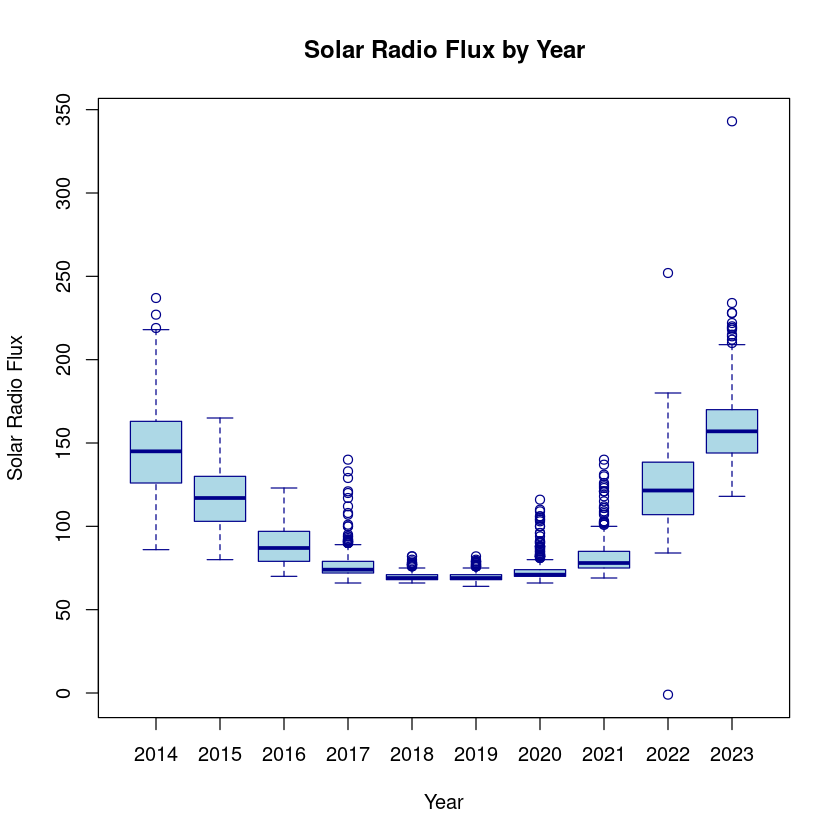

In [59]:
#boxplot of radio flux data
df$Date <- as.Date(df$Date, format = "%Y-%m-%d")
df$Year <- format(df$Date, "%Y")
df$Year <- as.factor(df$Year)
boxplot(RadioFlux ~ Year, data = df,
        main = "Solar Radio Flux by Year",
        xlab = "Year",
        ylab = "Solar Radio Flux",
        col = "lightblue",
        border = "darkblue")

In [60]:
#partitioning the dataset
library(caret)
set.seed(1)
partition <- createDataPartition(y=df$RadioFlux, p = 0.8, list = FALSE)
trainData <- df[partition, ]
testData <- df[-partition, ]

In [61]:
#generated a model to predict solar flux based on the sunspot number
#and individaul number of X-ray and optical solar flares
model <- lm(RadioFlux ~ SunspotNumber + XRayC + XRayM + XRayX 
            + OpticalS + Optical1 + Optical2 + Optical3, 
            data = trainData)

In [62]:
#determining the accuracy of the model at predicting solar flux
predictions <- predict(model, newdata = testData)
ss_total <- sum((testData$RadioFlux - mean(testData$RadioFlux))^2)
ss_residual <- sum((testData$RadioFlux - predictions)^2)
r_squared <- 1 - (ss_residual / ss_total)
r_squared
#an r-squared value of 0.82 means that 82% of the variance in the 
#sunspot number and the individual number of X-ray 
#and optical solar flares is explained by the model.
#the model is good at capturing the relationship between 
#radio flux and the dependent variables

[1] 0.8264692

In [63]:
#testing the the model for a specific case to predict
#solar radio flux for a day when 96 sunspots are observed
#and a single solar flare with X-ray radiation 
#that is classified as a C-class flare occurs

new_prediction <- data.frame(
  SunspotNumber = 96,
  XRayC = 1,
  XRayM = 0,
  XRayX = 0,
  OpticalS = 0,
  Optical1 = 0,
  Optical2 = 0,
  Optical3 = 0
)

predicted_flux <- predict(model, newdata = new_prediction)
predicted_flux
#I am fairly confident in the answers, 
#since r-squared has shown a pretty reliable relationship 
#between radio flux and other variables

1 
122.6011